In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('../'))
from utils.parse_data import load_trained_model
from interp_helpers import plot_attribution_all_targets
import interp_helpers as interp
%load_ext autoreload
%autoreload 2

sns.set_theme(
    style='ticks',
    font_scale=1.0,
    rc={'axes.labelsize': 11,
        'axes.titlesize': 11,
        'savefig.transparent': True,
        'legend.title_fontsize': 11,
        'legend.fontsize': 10,
        'legend.borderpad': 0.2,
        'figure.titlesize': 11,
        'figure.subplot.wspace': 0.1,
        })

In [2]:
from feature_attribution import PerturbationAnalyzer

In [3]:
# Load the model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

run = 36 # fm.get_latest_run()
model, model_info, config = load_trained_model(run, model_name=None, device=device, weights_only=False)

Using cpu device


In [ ]:
# vocab = ['R', 'r', 'L', 'l']
# stoi = {ch: i for i, ch in enumerate(vocab)}
# itos = {i: ch for i, ch in enumerate(vocab)}
T = model_info['dataloader']['Sequence length (T)']

num_sequences = 300
events, sequences, counts = interp.get_common_sequences(T, run=run, k=num_sequences)
print(f"Analyzing {num_sequences} sequences:\n{sequences[:20]}")

block_sequences  = interp.get_block_transition_sequences(events, T, high_port=1)

Analyzing 300 sequences:
['LLLLLL', 'RRRRRR', 'LLLLLl', 'RRRRRr', 'LLLLlL', 'RRRRrR', 'LLLlLL', 'LLlLLL', 'RRRrRR', 'LlLLLL', 'RRrRRR', 'lLLLLL', 'RrRRRR', 'rRRRRR', 'rLLLLL', 'lRRRRR', 'rrLLLL', 'llRRRR', 'RRRRrr', 'LLLLll']


In [227]:
sequences = interp.trim_leading_duplicates(block_sequences[10].values.tolist())
sequences

['LLLLLL',
 'LLLLLl',
 'LLLLll',
 'LLLllr',
 'LLllrR',
 'LllrRR',
 'llrRRR',
 'lrRRRR']

In [228]:
analyzer = PerturbationAnalyzer(model, method='embeddings')

## Embedding erasure attribution

Set activations for a particular input token at position $i$ within the sequence to 0 __after__ embedding the token (to bypass the challenge of finding a neutral token with which to mask the token).

Compute the difference between the logit predicted by the output layer of the model for a given target token with and without the token at position $i$ in the sequence.

Optionally, call the function to return the difference in probabilities instead of logits, which seems more interpretable (?) because then the difference can simply be read as the change in probability of predicting the target token, given the inclusion of the input token.

**To address**: Does this truly avoid the challenge posed by finding a neutral mask as a raw input token? It seems that perhaps the model is still biased by perturbing the token embeddings.

In [229]:
fig, axs = analyzer.plot_attribution_contiguous_sequences(sequences, method='embedding_erasure', as_prob=True)

TypeError: 'SubFigure' object is not iterable

<Figure size 1680x200 with 0 Axes>

## Contrastive attribution

As an alternative to the above approach, instead of masking each input token, we instead compare the inclusion of each input token to a "baseline" defined by the average of the logits/probabilities when replacing that token with all other tokens in the vocabulary.

Clearly, this approach will become quite computationally expensive if the vocabulary or sequence length grows, but at least seems theoretically sound(?) and is doable for our small version of the model/task..

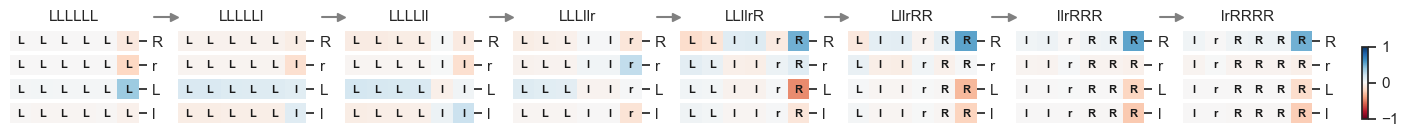

In [236]:
fig, axs = analyzer.plot_attribution_contiguous_sequences(sequences, method='contrastive', as_prob=True)

(<Figure size 210x120 with 5 Axes>,
 [array([<Axes: title={'center': 'LLLLLL'}>, <Axes: >, <Axes: >, <Axes: >],
        dtype=object)])

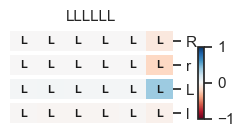

In [220]:
analyzer.plot_attribution_all_targets(sequences[:1], method='contrastive', ncols=1, as_prob=True)

[autoreload of feature_attribution failed: Traceback (most recent call last):
  File "/Users/celiaberon/miniforge3/envs/transformers/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/celiaberon/miniforge3/envs/transformers/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/celiaberon/miniforge3/envs/transformers/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/celiaberon/miniforge3/envs/transformers/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/celiaberon/miniforge3/envs/transformers/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 319, in update_instances
    refs = gc.get_referrers(old)
           ^^^^^^^^^^^^^^^^^^^^^
Key

AttributeError: 'float' object has no attribute 'reshape'

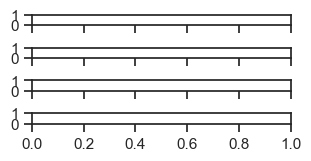

In [22]:
analyzer.plot_attribution_all_targets(sequences, method='layer_perturbation', ncols=1)

## LIME (Local Interpretable Model-agnostic Explanations)

Similar to other methods, begin by computing the baseline prediction from the input sequence for a given target token.

Next, randomly sample a collection of input sequences where each token has some probability of being replaced with a random alternative token from the vocabulary. For each of these perturbed sequences, compute the prediction for the target token. This creates a dataset of perturbed sequences and their corresponding predictions, on which we can then fit a linear model to learn the importance of each token (via fit coefficients).

Given the small size of the vocabulary, this appears to converge to a similar solution as the contrastive attribution approach.

In [13]:
def lime_attribution_contrastive(model, sequence, stoi, target_token_idx, n_samples=200):
    """LIME attribution using contrastive perturbation strategy."""
    from sklearn.linear_model import Ridge
    
    token_ids = [stoi[char] for char in sequence]
    seq_len = len(token_ids)
    vocab_size = len(stoi)
    
    # Get baseline prediction for original sequence
    input_tensor = torch.tensor([token_ids], dtype=torch.long).to(model.device)
    with torch.no_grad():
        base_logits, _ = model(input_tensor)
        base_probs = F.softmax(base_logits[0, -1], dim=0)
        base_score = base_probs[target_token_idx].item()
    
    # Generate samples where each token has some probability of being replaced
    # with a random alternative token from vocabulary
    perturbed_data = np.zeros((n_samples, seq_len))
    predictions = []
    
    for sample_idx in range(n_samples):
        # Decide which positions to perturb (with ~50% probability)
        perturb_mask = np.random.binomial(1, 0.5, size=seq_len)
        perturbed_seq = token_ids.copy()
        
        # For positions to perturb, choose random alternative tokens
        for pos in range(seq_len):
            if perturb_mask[pos] == 1:
                # Get a random token that's different from the original
                alt_tokens = [t for t in range(vocab_size) if t != token_ids[pos]]
                if alt_tokens:  # Make sure we have alternatives
                    perturbed_seq[pos] = np.random.choice(alt_tokens)
            
            # Record whether we kept original (0) or used alternative (1)
            perturbed_data[sample_idx, pos] = perturb_mask[pos]
        
        # Get prediction for perturbed sequence
        perturbed_tensor = torch.tensor([perturbed_seq], dtype=torch.long).to(model.device)
        with torch.no_grad():
            perturbed_logits, _ = model(perturbed_tensor)
            perturbed_probs = F.softmax(perturbed_logits[0, -1], dim=0)
            pred = perturbed_probs[target_token_idx].item()
            predictions.append(pred)
    
    # Fit interpretable model
    model_lime = Ridge(alpha=1.0)
    model_lime.fit(perturbed_data, predictions)
    
    # Return coefficients (negative because 1 means "replaced with alternative")
    # Negative coefficient means replacing hurts prediction → token is important
    return -model_lime.coef_

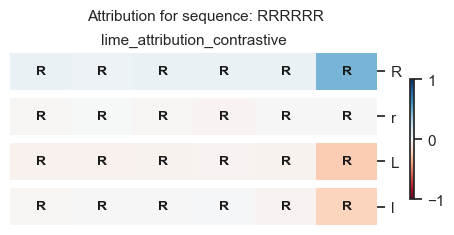

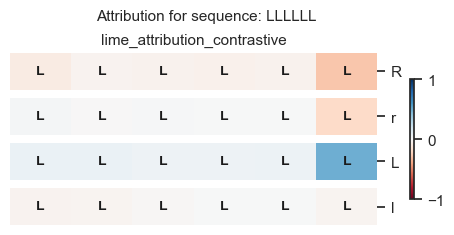

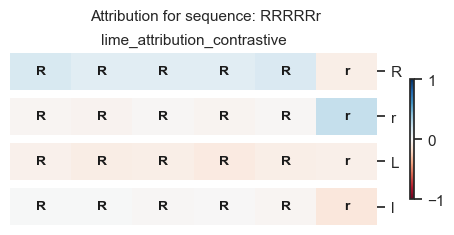

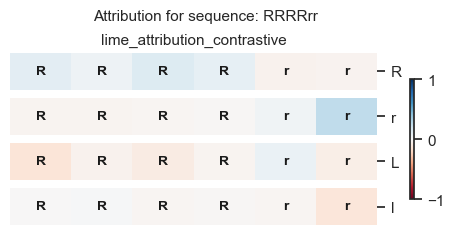

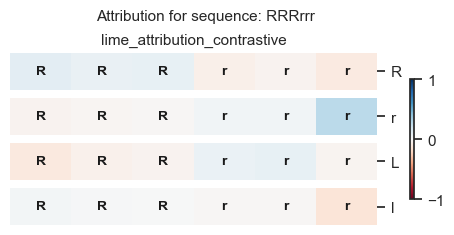

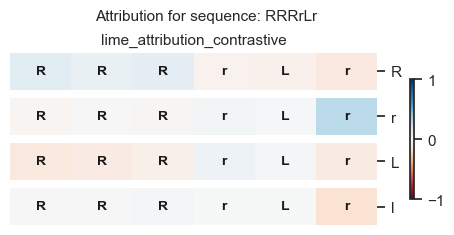

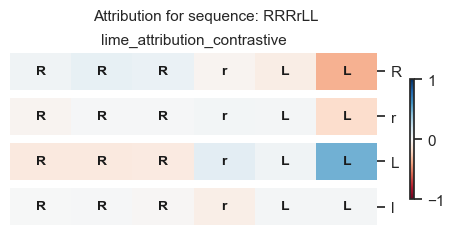

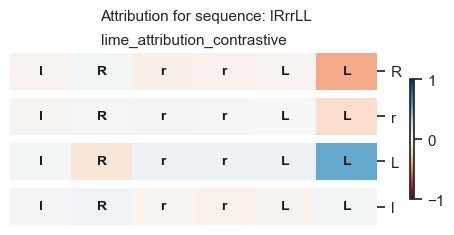

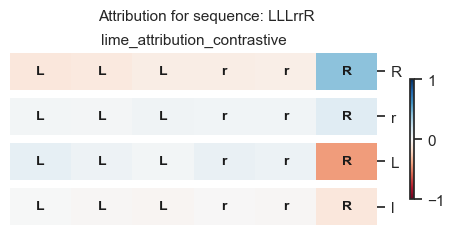

In [14]:
plot_attribution_all_targets(lime_attribution_contrastive, model, sequences, vocab, stoi)